In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
N_train = 5000
N_val = 5000
N_test = 5000

path = '/content/drive/MyDrive/Dataset/dati_progetto.csv'
df = pd.read_csv(path)

df_t_v = df[df['t'] != 10]
df_test = df[df['t'] == 10]

In [ ]:
X = torch.tensor(df_t_v['x'].values, dtype=torch.float32, requires_grad=True).reshape(-1,1)
Y = torch.tensor(df_t_v['y'].values, dtype=torch.float32, requires_grad=True).reshape(-1,1)
T = torch.tensor(df_t_v['t'].values, dtype=torch.float32, requires_grad=True).reshape(-1,1)

U = torch.tensor(df_t_v['u'].values, dtype=torch.float32).reshape(-1,1)
V = torch.tensor(df_t_v['v'].values, dtype=torch.float32).reshape(-1,1)
P = torch.tensor(df_t_v['p'].values, dtype=torch.float32).reshape(-1,1)

NN = 5000 #discretizzazione spaziale
TT = 200 #discretizzazione temporale

np.random.seed(123)

idx = np.random.choice(NN * TT - NN, N_train, replace=False)

x_train = X[idx, :].to(device)
y_train = Y[idx, :].to(device)
t_train = T[idx, :].to(device)
u_train = U[idx, :].to(device)
v_train = V[idx, :].to(device)
p_train = P[idx, :].to(device)
zeros_train = torch.zeros_like(x_train).to(device)

idx_val = np.setdiff1d(np.arange(NN * TT - NN), idx)
idx2 = np.random.choice(idx_val, N_val, replace=False)

x_val = X[idx2, :].to(device)
y_val = Y[idx2, :].to(device)
t_val = T[idx2, :].to(device)
u_val = U[idx2, :].to(device)
v_val = V[idx2, :].to(device)
p_val = P[idx2, :].to(device)

In [ ]:
x_test = torch.tensor(df_test['x'].values, dtype=torch.float32, requires_grad=True).reshape(-1,1).to(device)
y_test = torch.tensor(df_test['y'].values, dtype=torch.float32, requires_grad=True).reshape(-1,1).to(device)
t_test = torch.tensor(df_test['t'].values, dtype=torch.float32, requires_grad=True).reshape(-1,1).to(device)
u_test = torch.tensor(df_test['u'].values, dtype=torch.float32, requires_grad=True).reshape(-1,1).to(device)
v_test = torch.tensor(df_test['v'].values, dtype=torch.float32, requires_grad=True).reshape(-1,1).to(device)
p_test = torch.tensor(df_test['p'].values, dtype=torch.float32, requires_grad=True).reshape(-1,1).to(device)

(-2.0, 2.0)

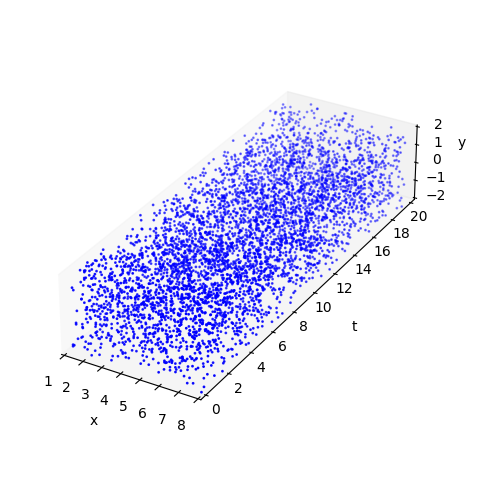

In [ ]:
x_graph, y_graph = x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy()
t_graph = t_train.cpu().detach().numpy()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter( x_graph, t_graph, y_graph,  c='b', s=1, marker='o')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('y', labelpad=4)
ax.yaxis.labelpad = 30

# Imposta la stessa scala su tutti e tre gli assi
ax.set_box_aspect([np.ptp(coord) for coord in [x_graph, t_graph, y_graph]])
ax.set_zticks([-2, -1, 0, 1, 2])
ax.set_yticks([0, 2, 4, 6, 8,10,12,14,16,18,20])
ax.grid(False)
ax.set_xlim(1, 8)
ax.set_ylim(0, 20)
ax.set_zlim(-2, 2)



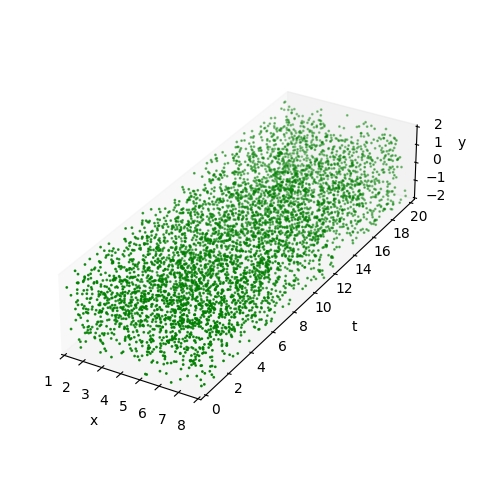

In [ ]:
x_graph, y_graph = x_val.cpu().detach().numpy(), y_val.cpu().detach().numpy()
t_graph = t_val.cpu().detach().numpy()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter( x_graph, t_graph, y_graph,  c='g', s=1, marker='o')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('y')
ax.yaxis.labelpad = 30
#ax.set_title('Validation Points')
# Imposta la stessa scala su tutti e tre gli assi
ax.set_box_aspect([np.ptp(coord) for coord in [x_graph, t_graph, y_graph]])
ax.set_zticks([-2, -1, 0, 1, 2])
ax.set_yticks([0, 2, 4, 6, 8,10,12,14,16,18,20])
ax.grid(False)
ax.set_xlim(1, 8)
ax.set_ylim(0, 20)
ax.set_zlim(-2, 2)
ax.grid(False)

In [ ]:
class FCN(nn.Module):
    '''
    Creazione di una NN fully-connected in PyTorch
    '''
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [ ]:
def pde(x,y,t,nu,model):

  output_pinn = model(torch.hstack((x, y, t)))

  u, v, p = output_pinn[:, 0:1], output_pinn[:, 1:2], output_pinn[:, 2:3]

  u_x = torch.autograd.grad(u, x,
                            torch.ones_like(u), create_graph=True)[0]
  u_xx = torch.autograd.grad(u_x, x,
                             torch.ones_like(u_x), create_graph=True)[0]
  u_y = torch.autograd.grad(u, y,
                            torch.ones_like(u), create_graph=True)[0]
  u_yy = torch.autograd.grad(u_y, y,
                             torch.ones_like(u_y), create_graph=True)[0]
  u_t = torch.autograd.grad(u, t,
                            torch.ones_like(u), create_graph=True)[0]

  v_x = torch.autograd.grad(v, x,
                            torch.ones_like(v), create_graph=True)[0]
  v_xx = torch.autograd.grad(v_x, x,
                             torch.ones_like(v_x), create_graph=True)[0]
  v_y = torch.autograd.grad(v, y,
                            torch.ones_like(v), create_graph=True)[0]
  v_yy = torch.autograd.grad(v_y, y,
                             torch.ones_like(v_y), create_graph=True)[0]
  v_t = torch.autograd.grad(v, t,
                            torch.ones_like(v), create_graph=True)[0]

  p_x = torch.autograd.grad(p, x,
                            torch.ones_like(p), create_graph=True)[0]
  p_y = torch.autograd.grad(p, y,
                            torch.ones_like(p), create_graph=True)[0]

  f = u_t + u * u_x + v * u_y + p_x - nu.to(device) * (u_xx + u_yy)
  g = v_t + u * v_x + v * v_y + p_y - nu.to(device) * (v_xx + v_yy)
  h = u_x + v_y

  return u, v, p, f, g, h

In [ ]:
def physics_loss(f,g,h,zeros_train, criterion):

  f_loss = criterion(f, zeros_train)
  g_loss = criterion(g, zeros_train)
  h_loss = criterion(h, zeros_train)

  return f_loss + g_loss + h_loss

In [ ]:
def data_loss(u, v, u_data, v_data, criterion):

  u_loss = criterion(u, u_data)
  v_loss = criterion(v, v_data)

  return u_loss + v_loss

In [ ]:
def loss_val_set(x_val, y_val, t_val, u_val, v_val, p_val, nu, model, zeros_train, criterion):

  o1, o2, o3, o4, o5, o6 = pde(x_val, y_val, t_val, nu, model)

  data_loss_val = data_loss(o1, o2, u_val, v_val, criterion)
  physics_loss_val = physics_loss(o4, o5, o6, zeros_train, criterion)

  loss_val = data_loss_val + physics_loss_val

  return loss_val


In [ ]:
'''
torch.manual_seed(123)

pinn = FCN(3,3,50,6).to(device)

num_iterations = 150000

nu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))

optimizer = torch.optim.Adam(list(pinn.parameters())+[nu], lr=1e-3)
criterion = nn.MSELoss()

losses = []
nus = []
val_losses = []

for i in range(num_iterations+1):

  optimizer.zero_grad()

  u, v, p, f, g, h = pde(x_train, y_train, t_train, nu, pinn)

  d_loss = data_loss(u, v, u_train, v_train, criterion)
  f_loss = physics_loss(f, g, h, zeros_train, criterion)

  loss = d_loss + f_loss

  losses.append(loss.detach())
  nus.append(nu.item())

  loss_val = loss_val_set(x_val, y_val, t_val, u_val, v_val, p_val, nu, pinn, zeros_train, criterion)
  val_losses.append(loss_val.detach())


  if i%1000 == 0:
    print(f"epochs: {i} and the loss on the training-set is {loss}")
    print(f"epochs: {i} and nu is {nu.item()}")
    print(f"epochs: {i} and the loss on the validation-set is {loss_val}\n")

  loss.backward(retain_graph=True)
  optimizer.step()

torch.save(pinn.state_dict(), '/content/drive/MyDrive/Dataset/model_noP_PRJ_T1_50N_6L.pt')
'''

epochs: 0 and the loss on the training-set is 0.9967986345291138
epochs: 0 and nu is 0.0
epochs: 0 and the loss on the validation-set is 0.9837730526924133

epochs: 1000 and the loss on the training-set is 0.0743810385465622
epochs: 1000 and nu is 0.022566942498087883
epochs: 1000 and the loss on the validation-set is 0.0790797546505928

epochs: 2000 and the loss on the training-set is 0.06454255431890488
epochs: 2000 and nu is 0.02800183743238449
epochs: 2000 and the loss on the validation-set is 0.06881526112556458

epochs: 3000 and the loss on the training-set is 0.05744412541389465
epochs: 3000 and nu is 0.02901494689285755
epochs: 3000 and the loss on the validation-set is 0.06148121878504753

epochs: 4000 and the loss on the training-set is 0.050492655485868454
epochs: 4000 and nu is 0.026486709713935852
epochs: 4000 and the loss on the validation-set is 0.05444685369729996

epochs: 5000 and the loss on the training-set is 0.02996997907757759
epochs: 5000 and nu is 0.022718381136

In [ ]:
'''
#salva
losses_t = torch.tensor(losses)
val_losses_t = torch.tensor(val_losses)
nus_t = torch.tensor(nus)
df_save_loss = pd.DataFrame({'training_loss': losses_t, 'validation_loss': val_losses_t, 'lamda1': nus_t})
df_save_loss.to_csv('/content/drive/MyDrive/Dataset/data_loss_noP_nu_50_6.csv', index=False)
'''

In [ ]:
df_loss_data = pd.read_csv('/content/drive/MyDrive/Dataset/data_loss_noP_nu_50_6.csv')

In [ ]:
df_loss_data.head()

,training_loss,validation_loss,lamda1
0,0.996799,0.983773,0.000000
1,0.847057,0.836513,-0.001000
2,0.710313,0.702219,-0.001984
3,0.583318,0.577745,-0.002948
4,0.465289,0.462390,-0.003895


In [ ]:
training_loss = df_loss_data['training_loss'].values
validation_loss = df_loss_data['validation_loss'].values
nu = df_loss_data['lamda1'].values

(0.0, 157.5)

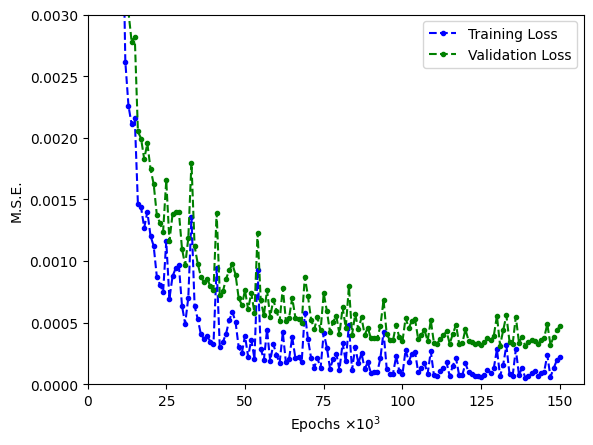

In [ ]:
x_plot = np.arange(151)

plt.plot(x_plot,training_loss[::1000],'o',linestyle='--',markersize=3, label='Training Loss',color='blue')
plt.plot(x_plot,validation_loss[::1000],marker='o',linestyle='--',markersize=3, color='g', label='Validation Loss')

plt.ylim(bottom=0,top=0.0030)
plt.xlabel(r'Epochs $\times 10^3$')
plt.ylabel('M.S.E.')
plt.xticks([0,25,50,75,100,125,150])

plt.legend()
plt.xlim(left=0)
#metti y in notazione scentifica

In [ ]:
new_model = FCN(3,3,50,6).to(device)
new_model.load_state_dict(torch.load('/content/drive/MyDrive/Dataset/model_noP_PRJ_T1_50N_6L.pt', map_location=torch.device('cpu')))

with torch.no_grad():
  plot_pinn = new_model(torch.hstack((x_test, y_test, t_test)))
  u_plot = plot_pinn[:, 0:1]
  v_plot = plot_pinn[:, 1:2]
  p_plot = plot_pinn[:, 2:3]


In [ ]:
x_plot = np.reshape(x_test.cpu().detach().numpy(), (50, 100))
y_plot = np.reshape(y_test.cpu().detach().numpy(), (50, 100))

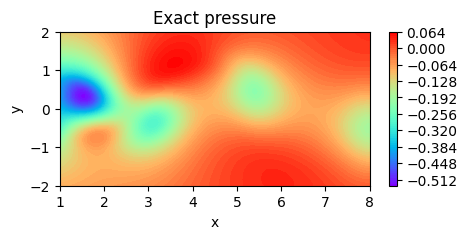

In [ ]:
pression_plot_true = np.reshape(p_test.cpu().detach().numpy(), (50, 100))
plt.figure(figsize=(5, 2))
plt.contourf(x_plot, y_plot, pression_plot_true, levels=80, cmap="rainbow")

plt.colorbar()
plt.title('Exact pressure')
plt.xlabel('x')
plt.ylabel('y')

plt.show()


Text(0, 0.5, 'y')

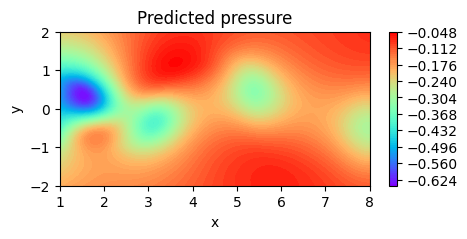

In [ ]:
pression_plot_pinn = np.reshape(p_plot.cpu().detach().numpy(), (50, 100))
plt.figure(figsize=(5, 2))
plt.contourf(x_plot, y_plot, pression_plot_pinn, levels=80, cmap="rainbow")
plt.colorbar()
plt.title('Predicted pressure')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

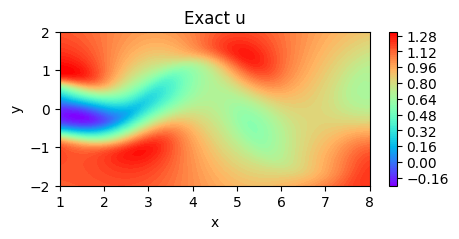

In [ ]:
u_plot_true = np.reshape(u_test.cpu().detach().numpy(), (50, 100))
plt.figure(figsize=(5, 2))
plt.contourf(x_plot, y_plot, u_plot_true, levels=80, cmap="rainbow")
plt.colorbar()
plt.title('Exact u')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

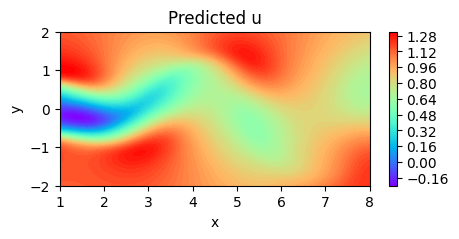

In [ ]:
u_plot_pinn = np.reshape(u_plot.cpu().detach().numpy(), (50, 100))
plt.figure(figsize=(5, 2))
plt.contourf(x_plot, y_plot, u_plot_pinn, levels=80, cmap="rainbow")
plt.colorbar()
plt.title('Predicted u')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

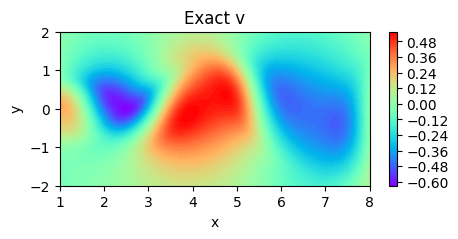

In [ ]:
v_plot_true = np.reshape(v_test.cpu().detach().numpy(), (50, 100))
plt.figure(figsize=(5, 2))
plt.contourf(x_plot, y_plot, v_plot_true, levels=80, cmap="rainbow")
plt.colorbar()
plt.title('Exact v')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

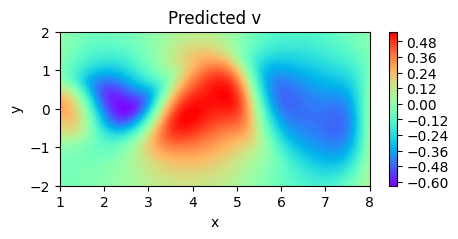

In [ ]:
v_plot_pinn = np.reshape(v_plot.cpu().detach().numpy(), (50, 100))
plt.figure(figsize=(5, 2))
plt.contourf(x_plot, y_plot, v_plot_pinn, levels=80, cmap="rainbow")
plt.colorbar()
plt.title('Predicted v')
plt.xlabel('x')
plt.ylabel('y')

In [ ]:
p_error = (((p_plot.reshape(1,-1)+0.1108) - p_test.reshape(1,-1)).norm() / p_test.reshape(1,-1).norm())*100
print(f'The error on p is {p_error:.2f} %')

The error on p is 3.06 %


In [ ]:
u_error = ((u_plot.reshape(1,-1) - u_test.reshape(1,-1)).norm() / u_test.reshape(1,-1).norm())*100
print(f'The error on u is {u_error:.2f} %')

The error on u is 0.62 %


In [ ]:
v_error = ((v_plot.reshape(1,-1) - v_test.reshape(1,-1)).norm() / v_test.reshape(1,-1).norm())*100
print(f'The error on v is {v_error:.2f} %')

The error on v is 2.51 %


In [ ]:
lamda_error =( abs(nu[-1]-0.01)/0.01)*100
print(f'The error on lambda is {lamda_error:.2f} %')

The error on lambda is 4.36 %
